# Modelos de Classificação
### Proposta: Construir um modelo que seja capaz de verificar se o resumo está coerente com tema abordado, basicamente o classificando com a disciplina correspondente.

# Bibliotecas necessárias

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import re
import string
!pip install nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras import layers
import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Função de Carregamento e Embaralhamento do dataset

In [ ]:
def get_data(nome_arquivo,shuffle):
    ds = pd.read_csv(nome_arquivo,encoding="utf-8")
    if shuffle:
        ds = ds.sample(frac=1)
    ds['texto'] = ds['texto'].apply(str)
    return ds

### Funções de preparação do Dataset
- Limpeza dos textos
- Remoção de urls, hífen, símbolos
- Remoção de Stop Words

In [ ]:
stop = set(stopwords.words("portuguese"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"",text)

def remove_punct(text):
    translator = str.maketrans("","",'!""#$%&\'()*+,./:;<=>?@[\\]^_`{|}~º')
    translator = str.maketrans("","",'!""#$%&\'()*+,./:;<=>?@[\\]^_`{|}~º')
    return text.translate(translator)

def remove_numbers(text):
    result = ''.join([i for i in text if not i.isdigit()])
    return result

def remove_hifen(text):
    translator = str.maketrans('-',' ')
    return text.translate(translator)

In [ ]:
pattern = re.compile(r"https?//(\S+|www)\.\S+")
def pat(df_t):
    for t in df_t.texto:
        matches = pattern.findall(t)
        for match in  matches:
            print(t)
            print(match)
            print(pattern.sub(r"",t))        
        if len(matches)> 0:
            break

In [ ]:
def make_test(df_t):
    df_t["texto"] = df_t.texto.map(remove_URL)
    #df_t["texto"] = df_t.texto.map(remove_punct)
    df_t["texto"] = df_t.texto.map(remove_hifen)
    #df_t["texto"] = df_t.texto.map(remove_numbers)
    df_t["texto"] = df_t.texto.map(remove_stopwords)

### Função para preparação da Sentença de Teste
- Aplica todas as funções acima em uma
  unica sentença

In [ ]:
def prepare(teste):
    teste = remove_URL(teste)
    #teste = remove_punct(teste)
    teste = remove_hifen(teste)
    teste = remove_stopwords(teste)    
    return teste

# Carregamento do Dataset
- Carregamento
- Embaralhamento
- Conversão texto para String 
- Limpeza e formatação do texto

### O Dataset utilizado pode ser encontrado em:
 - [train.csv](https://github.com/mateusns12/Modelos-de-Classificacao/blob/master/Modelo-Eletrica-Eletronica/train.csv)
 - [eval.csv](https://github.com/mateusns12/Modelos-de-Classificacao/blob/master/Modelo-Eletrica-Eletronica/eval.csv)

In [ ]:
train_csv = 'https://raw.githubusercontent.com/mateusns12/Modelos-de-Classificacao/master/Modelo-Eletrica-Eletronica/train.csv'
eval_csv = 'https://raw.githubusercontent.com/mateusns12/Modelos-de-Classificacao/master/Modelo-Eletrica-Eletronica/eval.csv'

In [ ]:
df = get_data(train_csv,1)

In [ ]:
pat(df)
make_test(df)

## Visualização da distribuição de frequencia de palavras por sentença
- Útil para definir o número máximo de palavras do processo de padding do tokenizador.

<Figure size 1152x720 with 0 Axes>

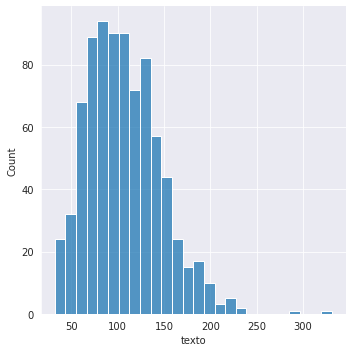

In [ ]:
import seaborn as sns
seqlen = df['texto'].apply(lambda x: len(x.split()))
sns.set_style('darkgrid')
plt.figure(figsize=(16,10))
sns.displot(seqlen)

In [ ]:
SEQ_LEN = 100

# Tokenizador BERT
O tokenizador BERT já incorpora tarefas como padding, inclusão de tokens especiais, e transformação do dataset em um array Numpy.

In [ ]:
!pip install transformers
from transformers import AutoTokenizer

     |████████████████████████████████| 4.0 MB 5.7 MB/s 
     |████████████████████████████████| 77 kB 5.4 MB/s 
     |████████████████████████████████| 895 kB 33.1 MB/s 
     |████████████████████████████████| 596 kB 42.8 MB/s 
     |████████████████████████████████| 6.5 MB 32.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/205k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
Xids = np.zeros((len(df),SEQ_LEN))
Xmask = np.zeros((len(df),SEQ_LEN))

In [ ]:
Xids.shape

(820, 100)

In [ ]:
for i, sequence in enumerate(df['texto']):
    tokens = tokenizer.encode_plus(sequence, max_length=SEQ_LEN, truncation= True, padding="max_length", 
                               add_special_tokens= True, return_token_type_ids= False, return_attention_mask= True, return_tensors= 'tf')
    Xids[i,:], Xmask[i,:] = tokens['input_ids'], tokens['attention_mask']

In [ ]:
Xids

array([[  101.,  3102.,  1223., ...,   774.,  2811.,   102.],
       [  101.,  2608.,  6854., ...,   117.,  3580.,   102.],
       [  101.,  1223.,  6770., ...,  8950., 17754.,   102.],
       ...,
       [  101.,  2981.,  1223., ...,     0.,     0.,     0.],
       [  101.,  1065.,  6636., ...,     0.,     0.,     0.],
       [  101.,  4574., 17837., ...,   695., 10264.,   102.]])

In [ ]:
Xmask

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [ ]:
arr = df['valor'].values
arr.size

820

In [ ]:
labels = np.zeros((arr.size, arr.max()+1))
labels.shape

(820, 2)

In [ ]:
labels[np.arange(arr.size),arr] = 1
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]])

# Dataset Modelo BERT
- Assim como o dataset Tensorflow, o datset BERT contém um array de Tokens e Labels, e uma terceira coluna de máscaras.
- No modelo BERT, tokens são chamados de IDs.
- As máscaras permitem com que o embedding seja multidirecional, ou seja o significado
é dado pelo contexto

### Montagem do dataset BERT, que será aplicado na camada de Embedding do modelo

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((Xids,Xmask,labels))

## Definindo Labels de treinamento
- Assim como no dataset original, haviam nomes para as colunas como 'texto' e 'valor'
 o modelo BERT exige labels para IDs e máscaras. 
- Estes são 'input_ids' e 'attention_mask'

### A função abaixo remapeia o dataset, adicionando estes labels como chaves

In [ ]:
def map_function(input_ids,mask,labels):
  return {'input_ids':input_ids, 'attention_mask':mask}, labels

In [ ]:
dataset = dataset.map(map_function)

### Exemplo
- Valores de IDs (tokens) e Máscara para a sentença 1:

In [ ]:
for i in dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(100,), dtype=float64, numpy=
array([  101.,  3102.,  1223.,  3957.,  9817.,  1089.,  9314.,   498.,
        3308., 12816., 10574.,  3184.,  9577., 18288.,  5506.,  3118.,
         695.,  1009.,   315.,   119.,  2590.,   117.,  5516.,   243.,
        3265.,  4476.,  5362.,  4438.,  3184.,   117.,  4431.,  9314.,
         498.,  1177.,  2383.,  5973.,   656.,  9287.,   498., 14491.,
         254.,   383., 22338.,  6337.,  3227.,   119.,  2801.,   117.,
        5931.,  1756.,  1181.,  9577.,   182.,   695.,  1009.,   315.,
       10485.,  5506.,  2630.,  1223.,   117.,  4956.,  1284.,  3077.,
        4455., 10440.,  1815.,   119.,  7012.,  5422.,   117.,  3308.,
        3077.,  4455.,  9158.,   695., 14758.,   925.,  2032.,   117.,
        4947.,  3024.,   119.,  4689.,  9158.,  3184.,  5506.,  3118.,
        5489.,  4979.,  3876.,  1223.,   119.,  1338.,   117.,  2064.,
        2453.,   774.,  2811.,   102.])>, 'attention_mask': <tf.Tensor: shape=(100,),

# Novo embaralhamento do modelo, distribuído em batches de 2 sentenças
- Os batches maiores permitem treinamentos mais rápidos, pois mais palavras são treinadas.
- No modelo Tensorflow, batches são de palavras.
- Deve haver um equilibrio, pois o modelo pode se "perder"

In [ ]:
dataset = dataset.shuffle(10000).batch(2)

In [ ]:
DS_LEN = len(list(dataset))
DS_LEN

410

## Sequências de Treinamento e Validação
- 90% dos dados para treinamento
- 10% para validação

In [ ]:
split = .9
train = dataset.take(round(DS_LEN*split))
val = dataset.skip(round(DS_LEN*split))

In [ ]:
from transformers import TFAutoModel
bert = TFAutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased', from_pt= True)

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

# Montagem do modelo TF.BERT
- Os arrays de IDs e máscaras são transformados em layers, sendo uma camada de IDs e outra camada de atenção.
- A camada de embedding receberá o modelo BERT pré treinado em Português, juntamente com os layers de IDs e Máscaras.

In [ ]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,),name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,),name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask = mask)[0]

## Hidden Layers e Output Layer
 
- Assim como nos Modelos Tensorflow, foi usado GlobalMaxPool1D, pela sua rapidez, mas pode ser usada qualquer outra operação matemática. 
- LSTMs são lentas no treinamento, mas obtêm alta precisão em poucas épocas. 
- Como os batches são sentenças inteiras, realiza-se uma normalização. Reduz a quantidade de épocas necessárias.
- Os próximos layers serão os layers densos, responsáveis pela forma e complexidade do modelo.
- O layer final irá retornar os valores previstos No exemplo, são apenas 2 valores.

In [ ]:

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(64, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(32, activation='relu')(X)
Y = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(X)

model = tf.keras.Model(inputs=[input_ids,mask],outputs=Y)

## Importante 
- O BERT contém layers que podem ser retreinados. Isso não é interessante pois são diversos parametros que podem atrasar o treinamento. Para isso usa-se o seguinte:

In [ ]:
model.layers[2].trainable = False

## Finalização do modelo
- Realizada com a função "sumary()".
- Exibe todas as características dos layers, e quantidadade de parâmetros do treinamento.
- Nota-se que o BERT contém milhões de parâmetros, enquanto o dataset contém cerca de 52 mil. Apenas estes serão treinados.

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108923136   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

# Definição da Função Loss, métrica e compilação
- A função loss é definida de acordo com o output layer, pois determina a quantidade de neurônios finais.
- A métrica é a propriedade que será rastreada durante o treinamento. Utilizando 'acc', será observada a precisão.
- O Otimizador influencia na velocidade e performance do modelo.

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001,decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()  # categorical = one-hot
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

# Treinamento e Validação
- Modelo sendo treinado com 40 épocas,

In [ ]:
import time
start = time.perf_counter()

history = model.fit(train, validation_data=val, epochs=40, verbose = 2)

finish = time.perf_counter()
print(f'\nFinished in {round(finish-start, 2)} second(s)')

Epoch 1/40
369/369 - 73s - loss: 0.7426 - accuracy: 0.5894 - val_loss: 0.4813 - val_accuracy: 0.8049 - 73s/epoch - 199ms/step
Epoch 2/40
369/369 - 40s - loss: 0.6478 - accuracy: 0.6179 - val_loss: 0.4981 - val_accuracy: 0.7439 - 40s/epoch - 108ms/step
Epoch 3/40
369/369 - 33s - loss: 0.5942 - accuracy: 0.6856 - val_loss: 0.4610 - val_accuracy: 0.7195 - 33s/epoch - 90ms/step
Epoch 4/40
369/369 - 33s - loss: 0.5951 - accuracy: 0.7046 - val_loss: 0.3340 - val_accuracy: 0.8415 - 33s/epoch - 88ms/step
Epoch 5/40
369/369 - 33s - loss: 0.5872 - accuracy: 0.6883 - val_loss: 0.3679 - val_accuracy: 0.8537 - 33s/epoch - 90ms/step
Epoch 6/40
369/369 - 32s - loss: 0.5808 - accuracy: 0.6843 - val_loss: 0.3154 - val_accuracy: 0.8537 - 32s/epoch - 87ms/step
Epoch 7/40
369/369 - 32s - loss: 0.5602 - accuracy: 0.7087 - val_loss: 0.3417 - val_accuracy: 0.8780 - 32s/epoch - 86ms/step
Epoch 8/40
369/369 - 32s - loss: 0.5708 - accuracy: 0.7019 - val_loss: 0.2825 - val_accuracy: 0.9146 - 32s/epoch - 86ms/ste

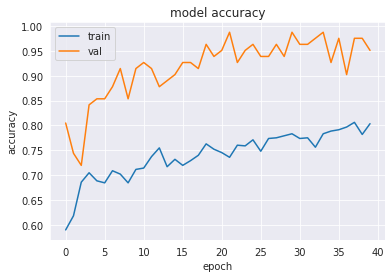

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

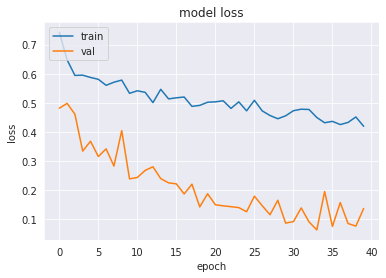

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

# Carregamento e preparação do Dataset de Testes
- O dataset de testes passa pelo mesmo processo de limpeza e tokenização.

In [ ]:
dt = get_data(eval_csv,1)
pat(dt)
make_test(dt)

In [ ]:
Tids = np.zeros((len(dt),SEQ_LEN))
Tmask = np.zeros((len(dt),SEQ_LEN))

In [ ]:
for i, sequence in enumerate(dt['texto']):
    tokensT = tokenizer.encode_plus(sequence, max_length=SEQ_LEN, truncation= True, padding="max_length", 
                               add_special_tokens= True, return_token_type_ids= False, return_attention_mask= True, return_tensors= 'tf')
    Tids[i,:], Tmask[i,:] = tokensT['input_ids'], tokensT['attention_mask']

In [ ]:
arrT = dt['valor'].values
labelsT = np.zeros((arrT.size, arrT.max()+1))
labelsT[np.arange(arrT.size),arrT] = 1

In [ ]:
datasetT = tf.data.Dataset.from_tensor_slices((Tids,Tmask,labelsT))

In [ ]:
datasetT = datasetT.map(map_function)

In [ ]:
datasetT = datasetT.batch(2)

In [ ]:
def remap_function(input_ids,mask):
  return {'input_ids':input_ids,'attention_mask':mask}

In [ ]:
def precision(test_labels,predictions):
    counter = len(test_labels)
    list_c = [i for i,j in zip(predictions,test_labels) if i == j]
    return len(list_c)/counter*100

In [ ]:
test_sentences = dt.texto.to_numpy()
test_labels = dt.valor.to_numpy()

In [ ]:
predictions_t = model.predict(datasetT)
#predictions_t = [np.argmax(element) for element in predictions_t]
print(predictions_t)
#print(precision(test_labels,predictions_t))

[[1.09012023e-01 8.90987933e-01]
 [9.87526953e-01 1.24730971e-02]
 [9.98964906e-01 1.03510369e-03]
 [9.66479957e-01 3.35201211e-02]
 [6.47579059e-02 9.35242057e-01]
 [1.18047006e-04 9.99881983e-01]
 [8.56648088e-01 1.43351942e-01]
 [9.99997854e-01 2.19118283e-06]]


# Testes com sentenças avulsas
- É possivel testar o modelo diretamente em um resumo, basta que o texto passe pelo mesmo processo de limpeza, formatação e tokenização. A função abaixo automatiza esse processo.

In [ ]:
def previsao(teste,modelT):
  teste = prepare(teste)
  tokensT = tokenizer.encode_plus(teste, max_length=SEQ_LEN, truncation= True, 
                                  padding="max_length", add_special_tokens= True, 
                                  return_token_type_ids= False, 
                                  return_attention_mask= True, return_tensors= 'tf')
  TTID, TTM = tokensT['input_ids'], tokensT['attention_mask']
  TT_seq = tf.data.Dataset.from_tensor_slices((TTID,TTM))
  TT_seq = TT_seq.map(remap_function)
  TT_seq = TT_seq.batch(2)  
  predictionsT= modelT.predict(TT_seq)  
  result = np.argmax(predictionsT)
  return result


In [ ]:
teste_1 = "O objetivo deste trabalho é propor um algoritmo para realizar a identificação de padrões na vocalização suína, visando determinar o nível do bem-estar do animal. Tal análise foi proposta uma vez que o bem-estar animal é um assunto cada vez mais abordado no mundo todo, principalmente quando os animais são criados para o abate. Dessa forma, a criação de um método em que haja o mínimo de contato com os animais se faz importante, evitando que tal contato altere o comportamento do animal e, conseqüentemente, o resultado da análise de seu bem-estar. Por essas características, foi proposto um método de análise dos sons emitidos pelos suínos com base na utilização de uma Rede Neural Artificial do tipo Radial Basis Function, a qual possui como elementos de treinamento e operação um conjunto de características extraídas através da Transformada Discreta Wavelet de sinais sonoros pré-gravados. As características obtidas dos sinais foram as energias das bandas críticas relativas à Escala Bark e a diferença entre as energias das bandas adjacentes, além dimensão fractal do sinal. Através desse método foram analisados dois tipos de sinais sonoros: a vocalização de leitões saudáveis e de leitões acometidos por uma doença chamada Artrite Traumática; e a vocalização de suínos adultos em situações de conforto e desconforto. Os resultados demonstram que a análise proposta atingiu bons patamares de acerto na determinação do bem-estar do animal"
#eletronica1

In [ ]:
previsao(teste_1,model)

1

In [ ]:
teste_2 = "Produzindo inicialmente motores elétricos, a WEG ampliou suas atividades a partir da década de 80, com a produção de componentes eletroeletrônicos, produtos para automação industrial, transformadores de força e distribuição, tintas líquidas e em pó e vernizes eletroisolantes. A empresa se consolidou não só como fabricante de motores, mas como fornecedora de sistemas elétricos industriais completos."
#eletrica0

In [ ]:
previsao(teste_2,model)

0

In [ ]:
teste_3 = "Numa definição mais abrangente, podemos dizer que a eletrônica é o ramo da ciência que estuda o uso de circuitos formados por componentes elétricos e eletrônicos, com o objetivo principal de representar, armazenar, transmitir ou processar informações além do controle de processos e servomecanismos. Sob esta ótica, também se pode afirmar que os circuitos internos dos computadores (que armazenam e processam informações), os sistemas de telecomunicações (que transmitem informações), os diversos tipos de sensores e transdutores (que representam grandezas físicas - informações - sob forma de sinais elétricos) estão, todos, dentro da área de interesse da eletrônica."
#eletronica1

In [ ]:
previsao(teste_3,model)

1

In [ ]:
teste_4 = "projeto visa nova abordagem sistema vigilância móvel autônomo. pulseira biométrica coleta dados sobre batimento cardíaco usuário envia, via bluetooth, módulo processamento, smartphone sistema operacional android, faz análise destes batimentos cardíacos define usuário passando alguma situação risco morte, extremo estresse. smartphone escreve, periodicamente, informações tempo imediato sobre usuário, localização geográfica batimentos cardíacos, banco dados nuvem que, vez, contém informações pessoais usuário, tipo sanguíneo, telefone contato emergencial, alergias, outros. premissa dados nuvem acessíveis todo momento servidor externo servirem base socorro médico emergencial, seja, sistema visa prover auxílio imediato maneira proativa autônoma, modo preservar vidas, sendo baixo custo alcançável grande parte população. realizados diversos testes simulações demonstrando adequabilidade sistema proposto situações problema apresentadas"
#eletronica1

In [ ]:
previsao(teste_4,model)

1

# Salvando um modelo BERT/Tensorflow
- Para o modelo ser utilizado na aplicação de fato (ex AutorIA), ele deve ser salvo, assim como o tokenizador.
- De forma diferente do Tensorflow, o tokenizador bert é salvo como um modelo. 
- Para isso usa-se as funções abaixo:

In [ ]:
def save_trained(model,bert,tokenizer):
  # model.save('./saved_models')
  # model.save_spec('./saved_models')
  # model.save_weights('./saved_models')
  bert.save_pretrained('./saved_BertModel')
  bert.save_weights('./saved_BertModel')
  tokenizer.save_pretrained('./saved_tokenizer')

In [ ]:
def load_trained(new_model,tokenizer2):
  from transformers import BertTokenizer
  new_model = TFAutoModel.from_pretrained('./saved_BertModel/')
  tokenizer2 = BertTokenizer.from_pretrained('./saved_tokenizer/')

## Salvar máscaras e IDs de um dataset, para treinamentos  futuros.
- Modelos BERT são pesados. 
- Arquivos .npy são mais eficientes do que arquivos csv
- Podem ser carregados direto no modelo.

In [ ]:
with open('xids.npy','wb') as f:
  np.save(f,Xids)
with open('xmask.npy','wb') as f:
  np.save(f,Xmask)
with open('labels.npy','wb') as f:
  np.save(f,labels)

In [ ]:
del Xids, Xmask, labels

In [ ]:
with open('xids.npy','rb') as fp:
  Xids = np.load(fp)
with open('xmask.npy','rb') as fp:
  Xmask = np.load(fp)
with open('labels.npy','rb') as fp:
  labels = np.load(fp)

# Referências e Citação

### BERTimbal, por NeuralmindAI.

In [ ]:
"""
@inproceedings{souza2020bertimbau,
    author    = {Souza, F{\'a}bio and Nogueira, Rodrigo and Lotufo, Roberto},
    title     = {{BERT}imbau: pretrained {BERT} models for {B}razilian {P}ortuguese},
    booktitle = {9th Brazilian Conference on Intelligent Systems, {BRACIS}, Rio Grande do Sul, Brazil, October 20-23 (to appear)},
    year      = {2020}
}

@article{souza2019portuguese,
    title={Portuguese Named Entity Recognition using BERT-CRF},
    author={Souza, F{\'a}bio and Nogueira, Rodrigo and Lotufo, Roberto},
    journal={arXiv preprint arXiv:1909.10649},
    url={http://arxiv.org/abs/1909.10649},
    year={2019}
}
"""

"\n@inproceedings{souza2020bertimbau,\n    author    = {Souza, F{'a}bio and Nogueira, Rodrigo and Lotufo, Roberto},\n    title     = {{BERT}imbau: pretrained {BERT} models for {B}razilian {P}ortuguese},\n    booktitle = {9th Brazilian Conference on Intelligent Systems, {BRACIS}, Rio Grande do Sul, Brazil, October 20-23 (to appear)},\n    year      = {2020}\n}\n\n@article{souza2019portuguese,\n    title={Portuguese Named Entity Recognition using BERT-CRF},\n    author={Souza, F{'a}bio and Nogueira, Rodrigo and Lotufo, Roberto},\n    journal={arXiv preprint arXiv:1909.10649},\n    url={http://arxiv.org/abs/1909.10649},\n    year={2019}\n}\n"